In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

Reference https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Target Distribution (Price)

## No Intervention

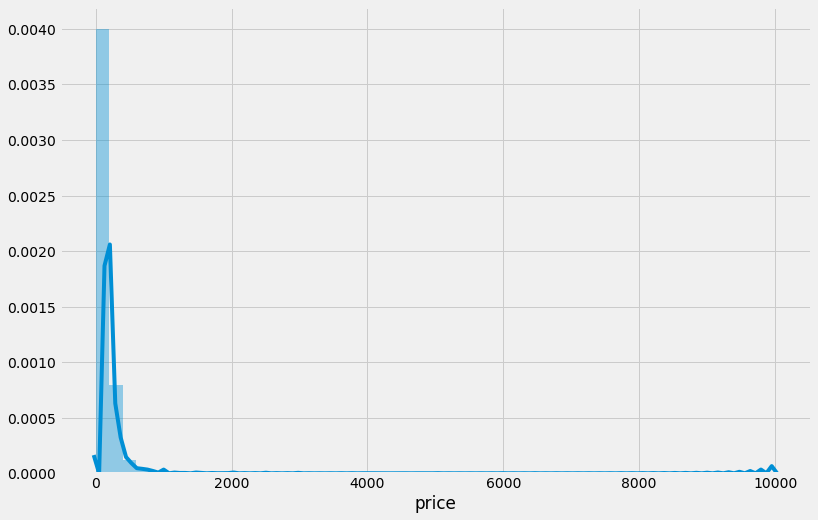

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(df['price']);

## Changing into numpy.log1p and removing outlier

In [4]:
df1 = df.copy()

In [5]:
df1['price'] = np.log1p(df1['price'])

**numpy.log1p**

Return the natural logarithm of one plus the input array, element-wise.

Calculates log(1 + x).

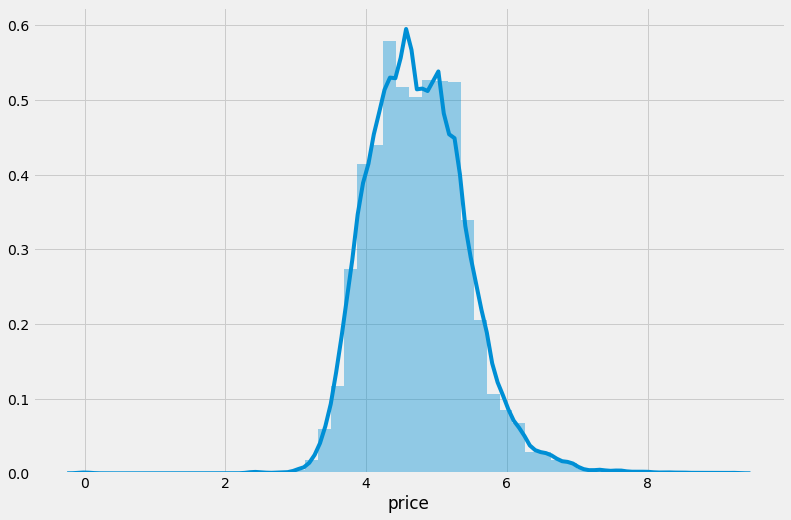

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(df1['price']);

In [7]:
# Removing Outlier with IQR
bttm_threshold, top_threshold, outlier_array = find_outlier(df1['price'])
bttm_threshold, top_threshold

(2.8655121125661713, 6.553467124521339)

In [8]:
print("Jumlah outlier =",df1[(df1['price'] < bttm_threshold) | (df1['price'] > top_threshold)].shape[0], "row")

Jumlah outlier = 637 row


In [9]:
df1 = df1[(df1['price'] >= bttm_threshold) & (df1['price'] <= top_threshold)] # 637 row deleted

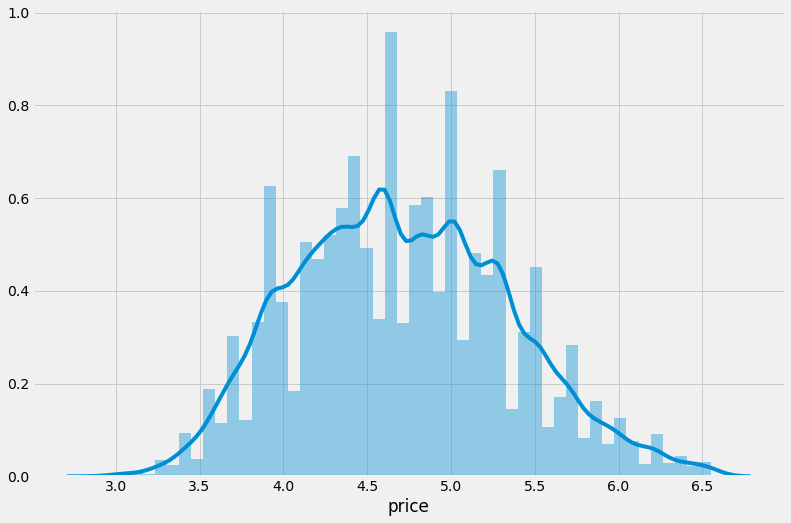

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(df1['price']);

# Determining Predictor

In [11]:
df1.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)
df1.fillna(0, inplace=True)
df1.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


# Encoding Categorical Feature

## With LabelEncoder()

In [12]:
df1_label_encoded = df1.copy()
df1_label_encoded['neighbourhood_group'] = LabelEncoder().fit_transform(df1_label_encoded['neighbourhood_group'])
df1_label_encoded['neighbourhood'] = LabelEncoder().fit_transform(df1_label_encoded['neighbourhood'])
df1_label_encoded['room_type'] = LabelEncoder().fit_transform(df1_label_encoded['room_type'])

In [13]:
df1_label_encoded.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1,107,40.64749,-73.97237,1,5.010635,1,9,0.21,6,365
1,2,126,40.75362,-73.98377,0,5.420535,1,45,0.38,2,355
2,2,93,40.80902,-73.94190,1,5.017280,3,0,0.00,1,365
3,1,41,40.68514,-73.95976,0,4.499810,1,270,4.64,1,194
4,2,61,40.79851,-73.94399,0,4.394449,10,9,0.10,1,0


## With pd.get_dummies()

In [14]:
df1_label_dummies = df1.copy()
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['room_type'], columns=['room_type'])
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['neighbourhood_group'], columns=['neighbourhood_group'])
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['neighbourhood'], columns=['neighbourhood'])
df1_label_dummies.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,40.64749,-73.97237,5.010635,1,9,0.21,6,365,0,1,...,0,0,0,0,0,0,0,0,0,0
1,40.75362,-73.98377,5.420535,1,45,0.38,2,355,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,5.017280,3,0,0.00,1,365,0,1,...,0,0,0,0,0,0,0,0,0,0
3,40.68514,-73.95976,4.499810,1,270,4.64,1,194,1,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,4.394449,10,9,0.10,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting and Train Dataset

## With label_encoder

In [15]:
x = df1_label_encoded.drop(columns=['price'])
y = df1_label_encoded['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

## With label_dummies

In [16]:
x1 = df1_label_dummies.drop(columns=['price'])
y1 = df1_label_dummies['price']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
x1_train = RobustScaler().fit_transform(x1_train)
x1_test = RobustScaler().fit_transform(x1_test)

# Modelling ML and Evaluation

## With label_encoder

### No Polynomial

In [65]:
model = Ridge()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'Model\t = {model}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
print('\n')

print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))

Model	 = Ridge()
RMSE	 = 0.45
MAE	 = 0.34
R2 Score = 50.35


cross_val_score = [0.43340737 0.49583727 0.4727634  0.50207163 0.53376671]


### Polynomial 2

In [66]:
model = Ridge()
poly_reg = make_pipeline(
    PF(2, include_bias=False),
    model
)

poly_reg.fit(x_train, y_train)
# predict
y_pred = poly_reg.predict(x_test)
print(f'Model\t = {model}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(poly_reg, x, y, scoring='neg_root_mean_squared_error',cv=5))

Model	 = Ridge()
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.02


cross_val_score = [-0.42751714 -0.41527899 -0.42745326 -0.4291539  -0.49688287]


## With label_dummies

In [67]:
model1 = Ridge()
model1.fit(x1_train, y1_train)
y1_pred = model1.predict(x1_test)
print(f'Model\t = {model1}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y1_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y1_test,y1_pred), 2)}')
print(f'R2 Score = {round( r2_score(y1_test,y1_pred) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(model1, x1, y1, scoring='neg_root_mean_squared_error',cv=5))

Model	 = Ridge()
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.34


cross_val_score = [-0.40565424 -0.40561853 -0.41292265 -0.41742855 -0.43741625]


### Tuning Model with label_dummies

In [68]:
alpha = np.linspace(3,4,10)

param = {'alpha':alpha}

model1 = Ridge()
model1_tuned = GridSearchCV(estimator=model1, param_grid=param, cv=5)

In [69]:
model1_tuned.fit(x1_train, y1_train)
print(model1_tuned.best_params_)

{'alpha': 3.0}


In [70]:
model1_tuned_GS = Ridge(alpha=3)
model1_tuned_GS.fit(x1_train, y1_train)
y1_pred = model1_tuned_GS.predict(x1_test)
print(f'Model\t = {model1_tuned_GS}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y1_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y1_test,y1_pred), 2)}')
print(f'R2 Score = {round( r2_score(y1_test,y1_pred) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(model1_tuned_GS,x1, y1, scoring='neg_root_mean_squared_error', cv=5))

Model	 = Ridge(alpha=3)
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.38


cross_val_score = [-0.40588219 -0.40573369 -0.41311709 -0.41729833 -0.43742573]
